Kaye Ng and Vivian Uy's submission for Programming Assessment #4

INTRNLP S17

### Importing packages

In [1]:
import pandas as pd
import nltk
import numpy as np
import html
import re
import pickle
import csv

from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

from symspellpy.symspellpy import SymSpell, Verbosity

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import make_pipeline as make_pipeline_imb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
pd.set_option('display.max_colwidth', -1)

In [2]:
def defaultPlotting():
    sns.set(rc={'figure.figsize': (12, 6)})
    sns.set_context("talk", rc={"font.size": 20, "axes.titlesize": 18, "axes.labelsize": 18})
    plt.rcParams['axes.spines.bottom'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.left'] = False
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.labelweight'] = 'bold'
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 14
    plt.rcParams['ytick.labelsize'] = 14
    plt.rcParams['legend.fontsize'] = 14
    plt.rcParams['figure.titlesize'] = 24
    
defaultPlotting()

In [ ]:
# from https://stackoverflow.com/a/53235657

def plot_confusion_matrix(y_predict):
    classes = ['negative', 'neutral', 'positive']
    mat = confusion_matrix(y_test, y_predict)
    
    cm_sum = np.sum(mat, axis=1, keepdims=True)
    cm_perc = mat / cm_sum.astype(float) * 100
    
    annot = np.empty_like(mat).astype(str)
    nrows, ncols = mat.shape
    
    for i in range(nrows):
        for j in range(ncols):
            c = mat[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(mat, square=True, annot=annot, fmt='', vmax=800,
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 14},
               cmap=sns.cm.rocket_r)
    
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.yticks(rotation=0)
    plt.title('Confusion matrix')
    
#     plt.savefig('confusion-matrix.png', bbox_inches="tight", dpi=300)
    plt.show()

In [3]:
slang_dict = {}
contractions = {}

def load_dictionary(dictionary, filename):
    with open(filename, "r") as myCSVfile:
        dataFromFile = csv.reader(myCSVfile, delimiter="=")

        for row in dataFromFile:
            dictionary[row[0].lower()] = row[1].lower()

        myCSVfile.close()

load_dictionary(slang_dict, "data/slang.txt")
load_dictionary(contractions, "data/contractions.txt")

In [ ]:
with open('pos_tag_corpus.pickle', 'rb') as handle:
    pos_set = pickle.load(handle)

In [5]:
# maximum edit distance per dictionary precalculation
max_edit_distance_dictionary = 2
prefix_length = 7

# create object
sym_spell = SymSpell(max_edit_distance_dictionary, prefix_length)

# term_index = 0  # column of the term in the dictionary text file
# count_index = 1  # column of the term frequency in the dictionary text file

if not sym_spell.load_dictionary("data/frequency_dictionary_en_82_765.txt", 0, 1):
    print("Dictionary file not found")

In [6]:
def get_correct_spelling(word):
    max_edit_distance_lookup = 2
    suggestion_verbosity = Verbosity.CLOSEST
    suggestions = sym_spell.lookup(word, suggestion_verbosity,
                                   max_edit_distance_lookup)

    # display suggestion term, term frequency, and edit distance
#     for suggestion in suggestions:
#         print("{}, {}, {}".format(suggestion.term, suggestion.distance,
#                                   suggestion.count))
    if len(suggestions) > 0:
        return suggestions[0].term
    else:
        return word

In [7]:
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True)

def tokenize_text(tweet):
    return [token for token in tokenizer.tokenize(tweet) if len(token) > 2]

In [8]:
pattern = re.compile(r"(\b[-'.]\b)|[\W_]")

def remove_punct(doc):
    return pattern.sub(lambda m: (m.group(1) if m.group(1) else " "), doc)

In [9]:
def reduce_word(word):
    p = re.compile(r"(.)\1{2,}")
    return p.sub(r"\1\1", word)

In [10]:
# from https://stackoverflow.com/a/46564234

class LemmatizationWithPOSTagger(object):
    def __init__(self):
        pass
    
    def get_wordnet_pos(self, treebank_tag):
        """
        return WORDNET POS compliance to WORDNET lemmatization (a,n,r,v) 
        """
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            # default pos in lemmatization is noun
            return wordnet.NOUN

In [11]:
def preprocess(word):
    word = get_correct_spelling(word)
    
    if word in pos_set:
        tag = pos_set[word]
    else:
        tag = nltk.pos_tag([word])[0][1]
    
    #filter out non-verbs, non-adjectives and non-adverbs then lemmatize
    if tag.startswith(("V", "J", "R")):
        return WordNetLemmatizer().lemmatize(word.strip().replace(".", ""),
                                      pos=LemmatizationWithPOSTagger().get_wordnet_pos(
                                                        tag))
    
    return ""

In [12]:
class TokenizeTweet(object):
    def __call__(self, doc):
        cleaned = []
        tokenize = tokenize_text(doc)

        for token in tokenize:

            if not token.startswith(("#", "http")):
                cleaned_token = reduce_word(token)
                cleaned_token = remove_punct(cleaned_token)

                if cleaned_token in slang_dict.keys():
    #                 print('slang found:', '\t', slang_dict[cleaned_token])
                    for word in slang_dict[cleaned_token].split():
                        cleaned_token = preprocess(word)
                        if cleaned_token.strip() != "":
                            cleaned.append(cleaned_token.strip())

                elif cleaned_token in contractions.keys():
    #                 print('contraction found:', '\t', contractions[cleaned_token])

                    for word in contractions[cleaned_token].split():
                        cleaned_token = preprocess(word)
                        if cleaned_token.strip() != "":
                            cleaned.append(cleaned_token.strip())

                else:
                    cleaned.append(preprocess(cleaned_token).strip())

        return cleaned

### Reading and inspecting the data

In [13]:
df = pd.read_csv('data/Virgin America and US Airways Tweets.csv', sep='\t')

df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it


### Understanding the corpus

In [14]:
df.dtypes

airline_sentiment    object
airline              object
text                 object
dtype: object

In [15]:
df.shape

(3417, 3)

In [16]:
df.describe(include='all')

,airline_sentiment,airline,text
count,3417,3417,3417
unique,3,2,3409
top,negative,US Airways,@USAirways thank you
freq,2444,2913,3


In [17]:
df.isnull().sum()

airline_sentiment    0
airline              0
text                 0
dtype: int64

In [18]:
df.airline_sentiment.value_counts()

negative    2444
neutral     552 
positive    421 
Name: airline_sentiment, dtype: int64

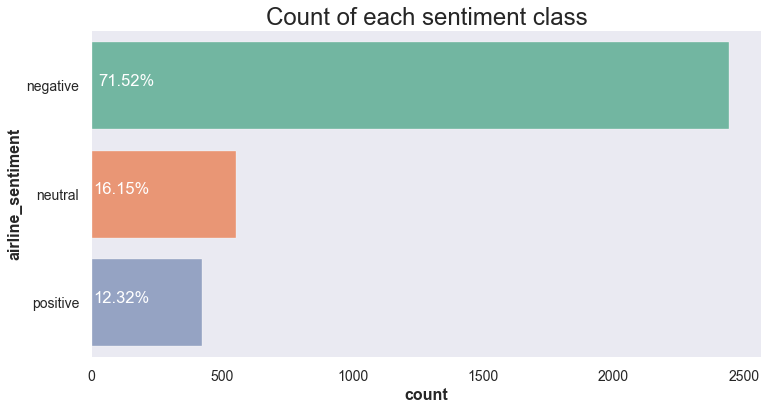

In [19]:
pct = ((df.airline_sentiment.value_counts() / df.airline_sentiment.count()) * 100)

ax = sns.countplot(y="airline_sentiment", data=df, palette="Set2", linewidth=0.3,
                   order = df.airline_sentiment.value_counts().index)

for i, p in enumerate(ax.patches):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate('{0:.2f}%'.format(pct[i]), (p.get_x() + 0.01 * width, p.get_y() + .45 * height), 
                color='white', ha='left', va='center', fontsize='small')

plt.title('Count of each sentiment class', fontsize=24)
plt.grid(False)

In [20]:
# get total words per class

def count_words(nArray):
    punct = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{}~'
    transtab = str.maketrans(dict.fromkeys(punct, ''))

    word_count = 0
    for sentence in nArray:
        tokens = nltk.word_tokenize(sentence.translate(transtab))
        
        # the translate portion just removed the punctuation
        word_count += len(tokens)

    return word_count

print("Total words in negative tweets:", count_words(df.loc[df.airline_sentiment == 'negative'].text.values))

print("Total words in neutral tweets:", count_words(df.loc[df.airline_sentiment == 'neutral'].text.values))

print("Total words in positive tweets:", count_words(df.loc[df.airline_sentiment == 'positive'].text.values))

Total words in negative tweets: 48095
Total words in neutral tweets: 8327
Total words in positive tweets: 5928


### Pre-processing the text

In [21]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"

In [22]:
df['text'] = df['text'].apply(lambda x: x.replace("\n", " "))

In [23]:
df.iloc[5].text

"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing. it's really the only bad thing about flying VA"

In [24]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'

In [25]:
df['text'] = df['text'].apply(lambda x: html.unescape(x))

In [26]:
df.iloc[3].text

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces & they have little recourse'

In [27]:
df.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,Virgin America,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing about it


**Problem**: how to convert symbols (incl. emoji) into words?

Example:

In [28]:
df.iloc[11].text

'@VirginAmerica I <3 pretty graphics. so much better than minimal iconography. :D'

<3 --> 'love' ?

**Problem**: typos

Example:

In [29]:
df.iloc[182].text

'@VirginAmerica Flight from BOS > LAS tomorrow was Cancelled Flightled. No notification; wait times are 1+ hour. Will you rebook on another airline?'

### Splitting into training and testing sets

In [30]:
X = df.text
y = df.airline_sentiment

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, # Features
    y, # Labels
    test_size = 0.3, # The defined test size; Training size is just 1 minus the test size
    random_state = 42 # So we can shuffle the elements, but with some consistency
)

print("=====\nTraining Data")
print("Document count: %s" % len(y_train))
labels, counts = np.unique(y_train, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(y_train)))
        
print("=====\nTesting Data")
print("Document count: %s" % len(y_test))
labels, counts = np.unique(y_test, return_counts=True)
for label, count in zip(labels, counts):
    print("%s: %s (%.4f)" % (label, count, count/len(y_test)))

=====
Training Data
Document count: 2391
negative: 1723 (0.7206)
neutral: 378 (0.1581)
positive: 290 (0.1213)
=====
Testing Data
Document count: 1026
negative: 721 (0.7027)
neutral: 174 (0.1696)
positive: 131 (0.1277)


### Extracting features from text

In [95]:
vectorizer = CountVectorizer(tokenizer=TokenizeTweet(), binary=True,
                             max_df=0.9, ngram_range=(1, 3), lowercase=False)

# vectorizer = TfidfVectorizer(tokenizer=TokenizeTweet(), binary=True,
#                              max_df=0.9, ngram_range=(1, 3), lowercase=False)

x = vectorizer.fit_transform(X_train)
count_vect_df = pd.DataFrame(x.todense(), columns=vectorizer.get_feature_names())

count_vect_df.head()

,,able,absolute,absolutely,absurd,abysmal,accept,acceptable,accidentally,act,...,yet tonnes,yet tonnes,yield,yield,yield,young,young,young american,yummy,zip
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Training the models

In [96]:
pipe = make_pipeline_imb(
    vectorizer,
#     RandomUnderSampler(),
    NearMiss(),
    MultinomialNB()
)

pipe.fit(X_train, y_train)

print(classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=pipe.predict(X_test)))

              precision    recall  f1-score   support

    negative   0.882353  0.332871  0.483384       721
     neutral   0.285311  0.580460  0.382576       174
    positive   0.240000  0.732824  0.361582       131

   micro avg   0.425926  0.425926  0.425926      1026
   macro avg   0.469221  0.548718  0.409180      1026
weighted avg   0.699084  0.425926  0.450736      1026



CountVectorizer, 90% threshold, binary, near miss undersampler

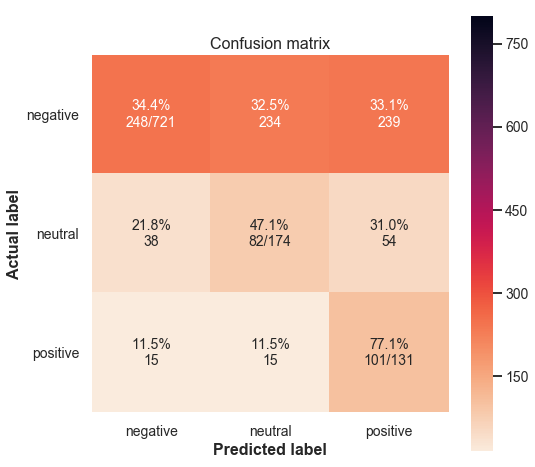

In [94]:
plot_confusion_matrix(pipe.predict(X_test))

CountVectorizer, 90% threshold, near miss undersampler

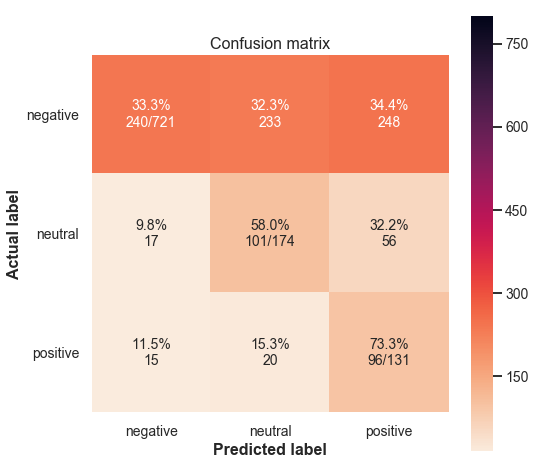

In [97]:
plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, binary, near miss undersampler

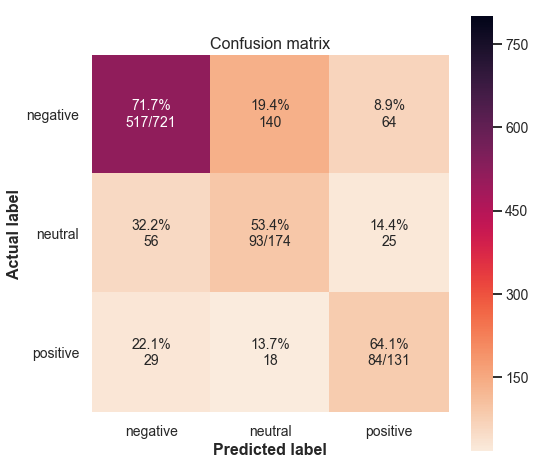

In [88]:
plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, near miss undersampler

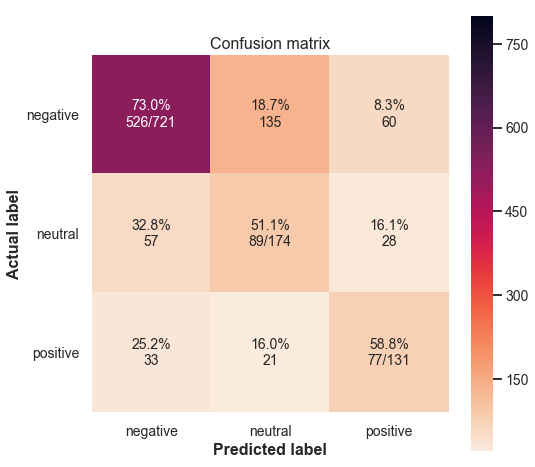

In [91]:
plot_confusion_matrix(pipe.predict(X_test))

CountVectorizer, 90% threshold, random undersampler

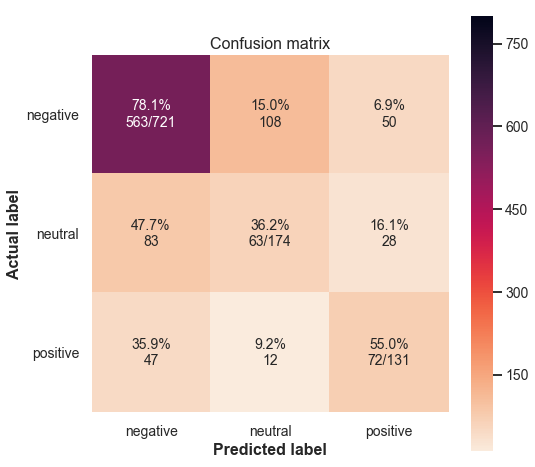

In [76]:
plot_confusion_matrix(pipe.predict(X_test))

CountVectorizer, 90% threshold, binary, random undersampler

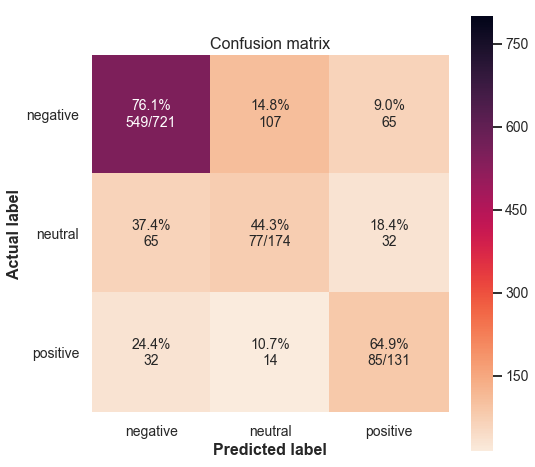

In [73]:
plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, random undersampler

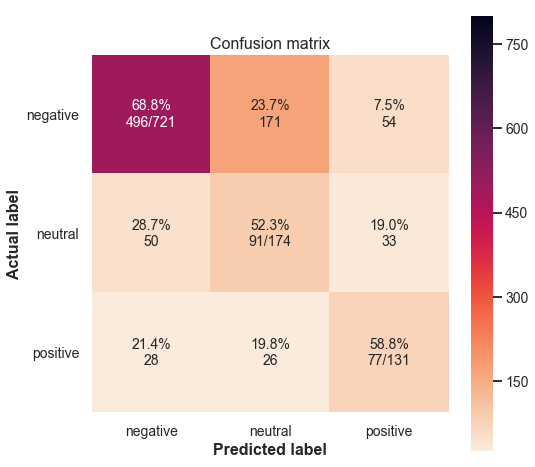

In [82]:
plot_confusion_matrix(pipe.predict(X_test))

TfidfVectorizer, 90% threshold, binary, random undersampler

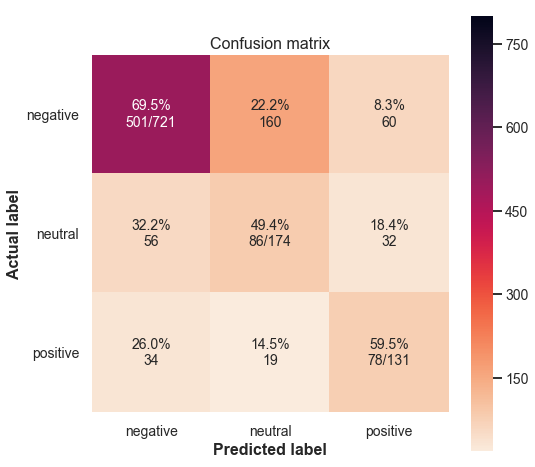

In [79]:
plot_confusion_matrix(pipe.predict(X_test))


********
# Program Writeup

...


********
## remove this afterwards!

### Data

You may follow the procedure done in the Python notebook if you're not sure what to do.

Study the data and understand what you have before moving to techniques.

The dataset to be used is a smaller version and only contains the sentiment (positive, neutral, negative), the airline in question (Virgin America and US Airways), and the text from the tweet.

There are 3,462 tweets in total. Its up to you how you understand the corpus and how its structure might affect the eventual learning model.


### Pre-process + Feature Extraction

Use at least 3 different feature extraction techniques out of, but not limited to, the following:
1. Term counts
2. Term frequency
3. Term frequency inverse document frequency
4. POS tags
5. Word sense counts
6. Word sense frequency
7. Sentiment-related features

You're expected to test out different parameters (e.g. # of POS tags, min/max document frequency) for each. It would be nice to report these, but you may stick with the best parameters based on experiments.
You may or may not perform pre-processing / cleaning, but you must talk about the effects of processing the data or leaving it raw.
1. Can preprocessing help in the boasting the accuracy?
2. Is the way you're tokenizing affecting the output?
3. Look at things before the learning bit and craft features that might contain loads of information for the classifier.


### Machine Learning

Limit yourselves to Naive Bayes. You are free to use other ML algorithms, but kindly just use one and focus on the effect of the techniques.
Kindly measure accuracy and F1 score (F-measure) for each model for comparison.
For simplicity, you can just do a single train and test split (like how the Python notebook shows).

There is a lot of room for you to do your thing here, but again, you are to focus on experimenting with different data pre-processing techniques and feature extraction methods. Don't overdo it and just focus on complying with the specs of the assignment. If you want to experiment with more, feel free to do so. :)

Please also use tools, like those from ScikitLearn or NLTK. Don't stress yourselves out doing too much. Search for implementations of the techniques.

You are also to create a write-up. Write all your observations, queries, comments, violent reactions, whatever. Which features did best/worst? Does it make sense that the best/worst features performed in such a manner? Was the dataset even good in the first place? The write-up has heavier weight than the program, so despite the program, focus on experimentation and note everything down.